In [ ]:
from datasets import load_dataset
datasets = load_dataset("Anthropic/hh-rlhf", data_dir="harmless-base")
datasets

In [ ]:
instance = datasets["train"][0]['chosen']
# Split by both 'Human' and "Assistant"
dialogue_list = instance.split('\n\n')
dialogue_list = [dialogue.strip() for dialogue in dialogue_list if dialogue.strip() != '']
res = []
for dialogue in dialogue_list:
    print(dialogue)
    if dialogue.startswith('Human:'): 
        res.append(dialogue.lstrip('Human:').strip())
    elif dialogue.startswith('Assistant'):
        res.append(dialogue.lstrip('Assistant:').strip())
    else:
        res[-1] += '\n\n' + dialogue
        
print(res)

In [86]:
from datasets import load_dataset

datasets = load_dataset('data/Anthropic')
datasets

DatasetDict({
    train: Dataset({
        features: ['query', 'reference'],
        num_rows: 104054
    })
    test: Dataset({
        features: ['query', 'reference'],
        num_rows: 5756
    })
})

In [84]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM

config = AutoConfig.from_pretrained("microsoft/DialoGPT-small")
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small", config=config)

In [87]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['query'], 
        padding=False, 
        truncation=True,
    )
    labels = tokenizer(
        examples['reference'], 
        padding=False, 
        truncation=True,
        
    )
    tokenized_inputs['labels'] = labels['input_ids']
    # tokenized_inputs['labels_attention_mask'] = labels['attention_mask']
    return tokenized_inputs

train_dataset = datasets['train'].map(
    tokenize_and_align_labels,
    batched=True,
).remove_columns(datasets['train'].column_names)
# sample  300 examples
train_dataset = train_dataset.select(range(300))

train_dataset

Map: 100%|██████████| 104054/104054 [00:10<00:00, 9822.23 examples/s]


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 300
})

In [88]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq

label_pad_token_id = tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=None,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=3,
    collate_fn=data_collator,
    shuffle=True,
)
inputs = next(iter(train_dataloader))
# print(inputs)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [33]:
import sys 
sys.dont_write_bytecode = True
from models import _prepare_decoding_inputs, _prepare_inputs
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=100,
)
new_inputs = _prepare_decoding_inputs(inputs)

# Forward pass for CLM
outputs = model(**new_inputs)
loss = outputs.loss
print('decoding loss: ', loss)
loss.backward()

# Update optimizer and scheduler
optimizer.step()

# Update learning rate
scheduler.step()

# Clear gradients
optimizer.zero_grad()

# Another forward pass for CLM
outputs = model(**new_inputs)
loss = outputs.loss
print('decoding loss: ', loss)

/home/yuli/anaconda3/envs/py3.10/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


decoding loss:  tensor(7.3938, grad_fn=<NllLossBackward0>)
decoding loss:  tensor(4.3627, grad_fn=<NllLossBackward0>)


In [89]:
import sys 
sys.dont_write_bytecode = True
import torch
from typing import Iterable
from models import get_stages, stages_decoding
from collections import defaultdict
from transformers import get_scheduler

stages = get_stages(
    config=config,
    token=None,
    model_name_or_path="microsoft/DialoGPT-small",
    num_stages=4,
    init_device=0,
    timing_info=defaultdict(list),
)

Model hidden dim 768, num layers 12, num heads 12, num parameters 124439808
Put stage GPTStartingStage (60647424 parameters) on device 0
Put stage GPTIntermediateStage (21263616 parameters) on device 1
Put stage GPTIntermediateStage (21263616 parameters) on device 2
Put stage GPTEndingStage (59862528 parameters) on device 3


In [95]:

# # stages is a list of GPT2LMHeadModel
# # This time: define optimizer and scheduler in this case
# # Collect all parameters from each stage
# all_parameters = []
# for stage in stages:
#     all_parameters.extend(list(stage.parameters()))
# optimizer = torch.optim.AdamW(all_parameters, lr=1e-4)
    
# schedulers = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=100,
# )
# losses = []
# total_steps = 3
# # Let's use 100 steps for demonstration
# for step, inputs in enumerate(train_dataloader):
#     inputs = next(iter(train_dataloader))
#     outputs = stages_decoding(stages, inputs)
#     loss = outputs[0]
#     losses.append(loss.item())
#     print('decoding loss: ', loss)
#     loss.backward()

#     # Update optimizer and scheduler
#     # print(optimizer.state_dict())
#     optimizer.step()
#     # Using custom step
#     # custom_step(schedulers.get_last_lr()[0])

#     # Update learning rate
#     schedulers.step()

#     # Clear gradients
#     optimizer.zero_grad()
    
#     if step == total_steps - 1:
#         break

# print('average loss: ', sum(losses) / len(losses))

# Save stages to disk
for i, stage in enumerate(stages):
    torch.save(stage.state_dict(), f"stage_{i}.pt")

In [91]:
outputs = stages_decoding(stages, inputs)
loss = outputs[0]
print('decoding loss: ', loss)

Forward pass for stage 0 on device 0
Forward pass for stage 1 on device 1
Forward pass for stage 2 on device 2
Forward pass for stage 3 on device 3
decoding loss:  tensor(2.1080, device='cuda:3', grad_fn=<BackwardHookFunctionBackward>)


In [97]:
# Load stages from disk
new_stages = get_stages(
    config=config,
    token=None,
    model_name_or_path="microsoft/DialoGPT-small",
    num_stages=4,
    init_device=4,
    timing_info=defaultdict(list),
)
# Adjust stage device
for i in range(len(new_stages)):
    new_stages[i].load_state_dict(torch.load(f"stage_{i}.pt"))

# Log each stage's device   
for i in range(len(new_stages)):
    print(f"Stage {i} device: {new_stages[i]._device}")

outputs = stages_decoding(new_stages, inputs)
loss = outputs[0]
print('decoding loss: ', loss)
start_stage = new_stages[0]
print(start_stage.h[-1].attn.c_attn.weight)

Model hidden dim 768, num layers 12, num heads 12, num parameters 124439808
Put stage GPTStartingStage (60647424 parameters) on device 4
Put stage GPTIntermediateStage (21263616 parameters) on device 5
Put stage GPTIntermediateStage (21263616 parameters) on device 6
Put stage GPTEndingStage (59862528 parameters) on device 7
Stage 0 device: 4
Stage 1 device: 5
Stage 2 device: 6
Stage 3 device: 7
Forward pass for stage 0 on device 4
Forward pass for stage 1 on device 5
Forward pass for stage 2 on device 6
Forward pass for stage 3 on device 7
decoding loss:  tensor(4.4385, device='cuda:7', grad_fn=<BackwardHookFunctionBackward>)
Parameter containing:
tensor([[-0.3059,  0.0133,  0.1252,  ..., -0.0344, -0.0264,  0.1572],
        [ 0.0984, -0.2404,  0.0218,  ..., -0.0875, -0.0248, -0.0478],
        [ 0.0717,  0.1152, -0.3469,  ..., -0.0480,  0.1561, -0.0623],
        ...,
        [ 0.2412,  0.3296,  0.0019,  ..., -0.1267, -0.0274, -0.0907],
        [ 0.1483,  0.0249,  0.1129,  ..., -0.1436, 

## Analysis

### Section 2.2

In [5]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

LABEL2METHOD = {
    "NaiveMix": "active",
    "Separate": "isolated",
    "LaMix-LLF": "interval",
    "LaMix-MLF": "interval-MLF",
}
LABEL2LINESTYLE = {
    "NaiveMix": "-",
    # "NaiveMix-balance": "-.",
    "Separate": "dotted",
    "LaMix-LLF": (0, (1, 10)),
    "LaMix-MLF": '-',
}

def plot_dual(lambda_=50, label1='Separate', label2='NaiveMix', label3=None, label4=None, label5=None, legend=True, legend_fontsize=14,
              figname=None, setting=None, load_balancing='random', num_nodes=2, model='DialoGPT-small', idles='bubble_rate',
              color1=sns.color_palette("deep")[0], 
              color2=sns.color_palette("deep")[1],):
    
    res1, res2, res3, res4, res5 = [], [], [], [], []
    res_dir = f"prof/{num_nodes}_node/lambda_{lambda_}"
    for retrain_rate in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,]:
        if setting:
            metric = json.load(open(f"{res_dir}/dialogpt-small/metrics_dialogpt-small_{setting}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res1.append(metric)
            metric = json.load(open(f"{res_dir}/dialogpt-medium/metrics_dialogpt-medium_{setting}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res2.append(metric)
        else:
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label1]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res1.append(metric)
            metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label2]}_poisson_{retrain_rate}.json"))
            metric["retrain_rate"] = retrain_rate
            res2.append(metric)
            if label3 is not None:
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label3]}_poisson_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                res3.append(metric)
            if label4 is not None:
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label4]}_poisson_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                res4.append(metric)
            if label5 is not None:
                metric = json.load(open(f"{res_dir}/{model}/metrics_{model}_{load_balancing}_{LABEL2METHOD[label5]}_poisson_{retrain_rate}.json"))
                metric["retrain_rate"] = retrain_rate
                res5.append(metric)
        
    res1 = pd.DataFrame(res1)
    res2 = pd.DataFrame(res2)
    res3 = pd.DataFrame(res3) if res3 else None
    res4 = pd.DataFrame(res4) if res4 else None
    res5 = pd.DataFrame(res5) if res5 else None

    # Let's plot the metrics, x-axis is retrain_rate, y-axis is the metric value
    os.makedirs("figure", exist_ok=True) 
    sns.set_theme(style="ticks")
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
    
    ax2 = axes[0].twinx()
    # ax.yaxis.grid(True, linestyle='dotted', which='major', color='grey', alpha=0.5)
    line1, = axes[0].plot(res1["retrain_rate"], res1["loss"], label=label1, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label1])
    line2, = ax2.plot(res1["retrain_rate"], res1["user_response"] * 1000, label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
    lines = [line1, line2]
    line1_1, = axes[0].plot(res2["retrain_rate"], res2["loss"], label=label2, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label2])
    line2_2, = ax2.plot(res2["retrain_rate"], res2["user_response"] * 1000, label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
    lines += [line1_1, line2_2]
    if res3 is not None:
        line1_2, = axes[0].plot(res3["retrain_rate"], res3["loss"], label=label3, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label3])
        line2_3, = ax2.plot(res3["retrain_rate"], res3["user_response"] * 1000, label=label3, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label3])
        lines += [line1_2, line2_3]
    if res4 is not None:
        line1_3, = axes[0].plot(res4["retrain_rate"], res4["loss"], label=label4, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label4])
        line2_4, = ax2.plot(res4["retrain_rate"], res4["user_response"] * 1000, label=label4, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label4])
        lines += [line1_3, line2_4]
    if res5 is not None:
        line1_4, = axes[0].plot(res5["retrain_rate"], res5["loss"], label=label5, marker='v', color=color1, linestyle=LABEL2LINESTYLE[label5])
        line2_5, = ax2.plot(res5["retrain_rate"], res5["user_response"] * 1000, label=label5, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label5])
        lines += [line1_4, line2_5]
    
    ax2.set_ylabel("Response time (ms)", fontsize=15, color=color2)
    ax2.tick_params(axis='y', colors=color2)
    labels = [line.get_label() for line in lines]
    axes[0].set_ylabel("Eval loss", fontsize=15, color=color1)
    axes[0].tick_params(axis='y', colors=color1)
    axes[0].set_xlabel("Retraining rate", fontsize=14)

    ax2 = axes[1].twinx()
    line1, = axes[1].plot(res1["retrain_rate"], res1[idles] * 100, label=label1, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label1])
    line2, = ax2.plot(res1["retrain_rate"], res1["end2end_latency"], label=label1, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label1])
    lines = [line1, line2]
    line1_1, = axes[1].plot(res2["retrain_rate"], res2[idles] * 100, label=label2, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label2])
    line2_2, = ax2.plot(res2["retrain_rate"], res2["end2end_latency"], label=label2, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label2])
    lines += [line1_1, line2_2]
    if res3 is not None:
        line1_2, = axes[1].plot(res3["retrain_rate"], res3[idles] * 100, label=label3, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label3])
        line2_3, = ax2.plot(res3["retrain_rate"], res3["end2end_latency"], label=label3, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label3])
        lines += [line1_2, line2_3]
    if res4 is not None:
        line1_3, = axes[1].plot(res4["retrain_rate"], res4[idles] * 100, label=label4, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label4])
        line2_4, = ax2.plot(res4["retrain_rate"], res4["end2end_latency"], label=label4, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label4])
        lines += [line1_3, line2_4]
    if res5 is not None:
        line1_4, = axes[1].plot(res5["retrain_rate"], res5[idles] * 100, label=label5, color=color1, marker='v', linestyle=LABEL2LINESTYLE[label5])
        line2_5, = ax2.plot(res5["retrain_rate"], res5["end2end_latency"], label=label5, color=color2, marker='x', linestyle=LABEL2LINESTYLE[label5])
        lines += [line1_4, line2_5]
        
    ax2.set_ylabel("End2end latency (s)", fontsize=15, color=color2)
    ax2.tick_params(axis='y', colors=color2)
    labels = [line.get_label() for line in lines]
    # Create a single legend for both lines together
    axes[1].set_ylabel("Bubble rate (%)", fontsize=15, color=color1)
    axes[1].tick_params(axis='y', colors=color1)
    axes[1].set_xlabel("Retraining rate", fontsize=14)
    if legend:
        ncol = 1
        if res2 is not None: ncol += 1
        if res3 is not None: ncol += 1
        if res4 is not None: ncol += 1
        if res5 is not None: ncol += 1
        fig.legend(lines, labels, loc='upper center', ncol=ncol * 2, bbox_to_anchor=(0.5, 1.12), fontsize=legend_fontsize)
    plt.tight_layout()
    if figname:
        plt.savefig(f"figure/{figname}.pdf", bbox_inches='tight')
    else:
        plt.savefig(f"figure/dialogpt_retraining_lambda={lambda_}_node={num_nodes}.pdf", bbox_inches='tight')
    plt.show()

#### 2-node

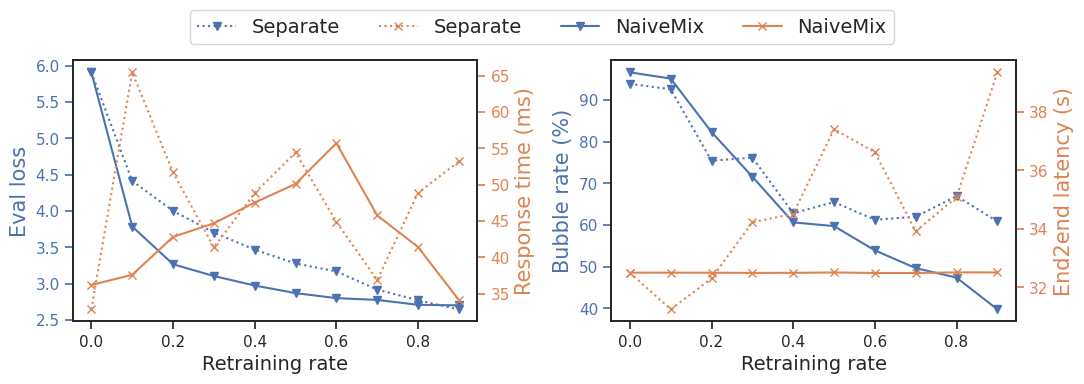

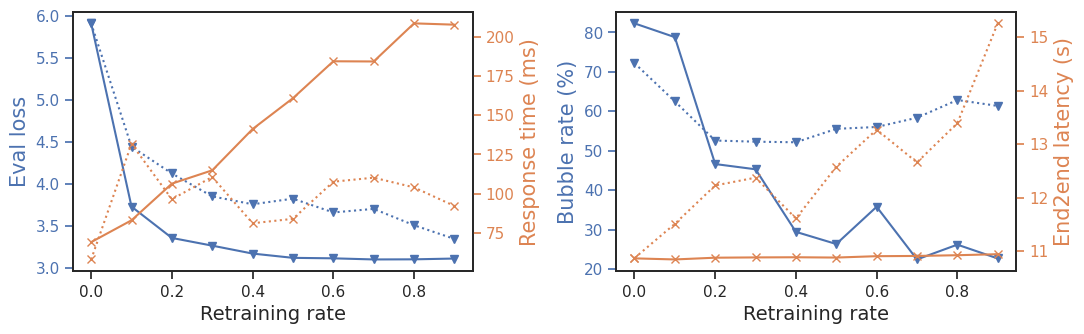

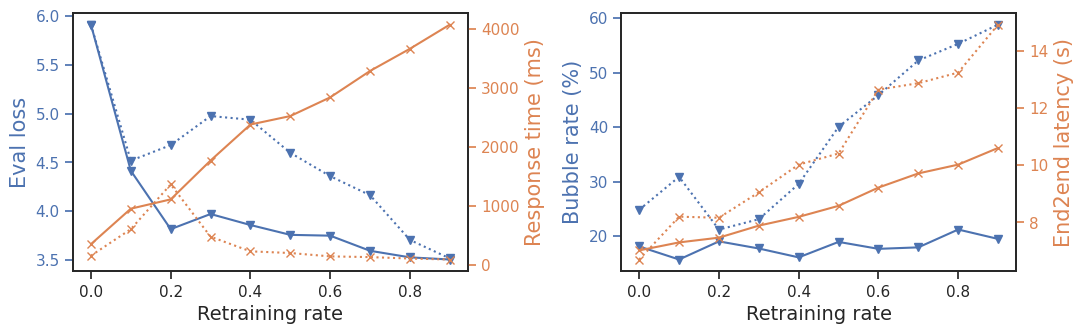

In [7]:
# plot_dual(lambda_=5, figname="dialogpt-small_sep_mix_lambda=5", model='DialoGPT-small', legend=True, num_nodes=2)
plot_dual(lambda_=10, figname="dialogpt-small_sep_mix_lambda=10", model='DialoGPT-small', legend=True, num_nodes=2)
# plot_dual(lambda_=20, figname="dialogpt-small_sep_mix_lambda=20", model='DialoGPT-small', legend=False, num_nodes=2)
plot_dual(lambda_=30, figname="dialogpt-small_sep_mix_lambda=30", model='DialoGPT-small', legend=False, num_nodes=2)
plot_dual(lambda_=50, figname="dialogpt-small_sep_mix_lambda=50", model='DialoGPT-small', legend=False, num_nodes=2)

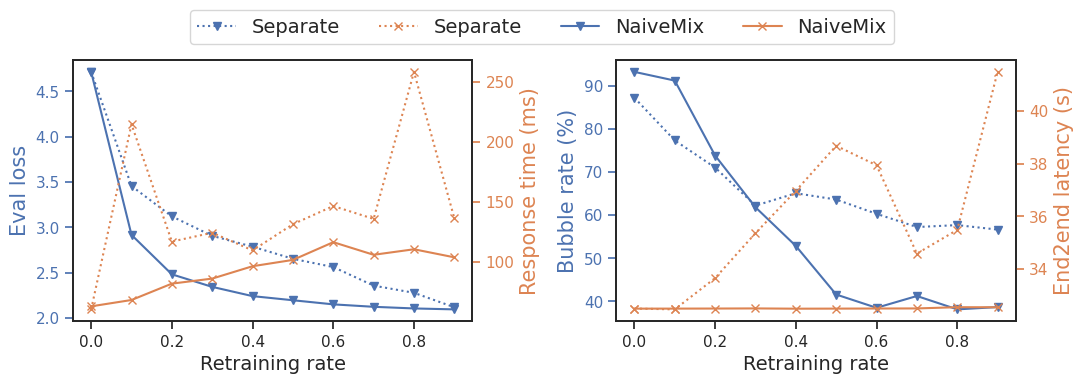

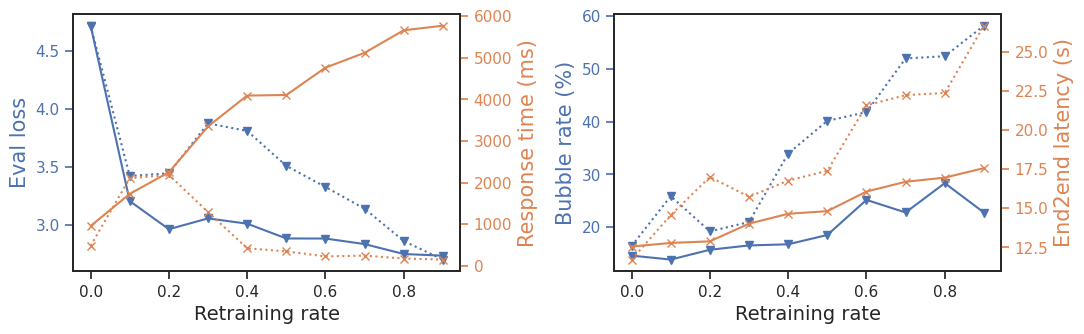

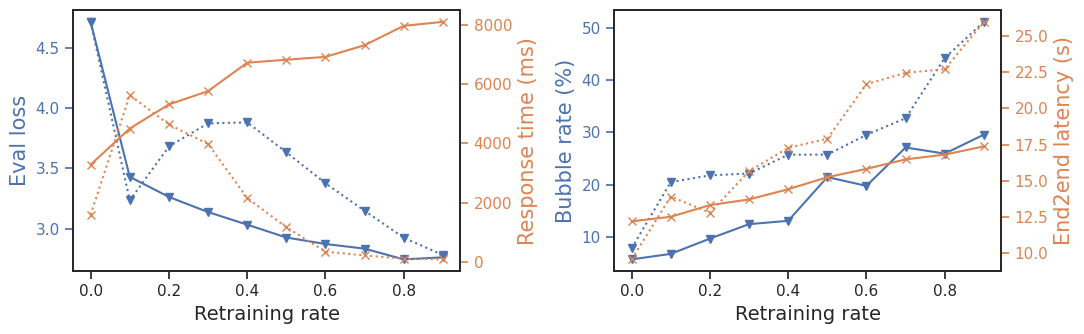

In [8]:
# plot_dual(lambda_=5, figname="dialogpt-medium_sep_mix_lambda=5", model='DialoGPT-medium', legend=True, num_nodes=2,)
plot_dual(lambda_=10, figname="dialogpt-medium_sep_mix_lambda=10", model='DialoGPT-medium', legend=True, num_nodes=2,)
# plot_dual(lambda_=15, figname="dialogpt-medium_sep_mix_lambda=15", model='DialoGPT-medium', legend=False, num_nodes=2,)
# plot_dual(lambda_=20, figname="dialogpt-medium_sep_mix_lambda=20", model='DialoGPT-medium', legend=False, num_nodes=2,)
# plot_dual(lambda_=25, figname="dialogpt-medium_sep_mix_lambda=25", model='DialoGPT-medium', legend=False, num_nodes=2,)
plot_dual(lambda_=30, figname="dialogpt-medium_sep_mix_lambda=30", model='DialoGPT-medium', legend=False, num_nodes=2)
plot_dual(lambda_=50, figname="dialogpt-medium_sep_mix_lambda=50", model='DialoGPT-medium', legend=False, num_nodes=2)

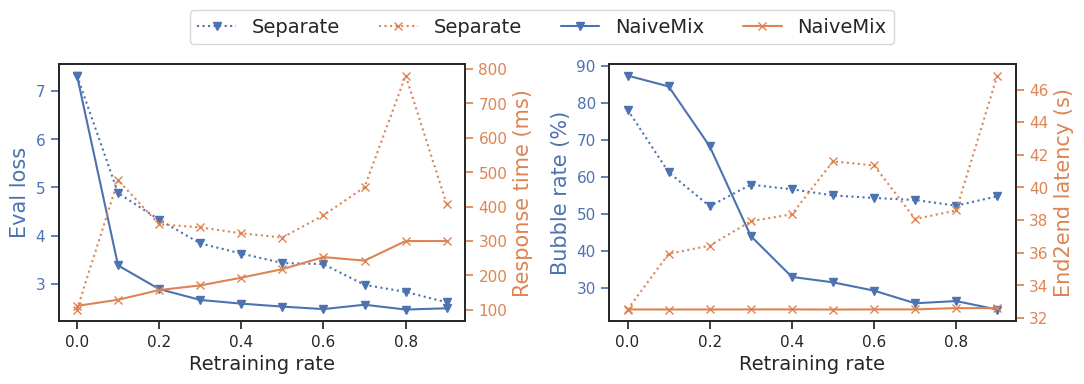

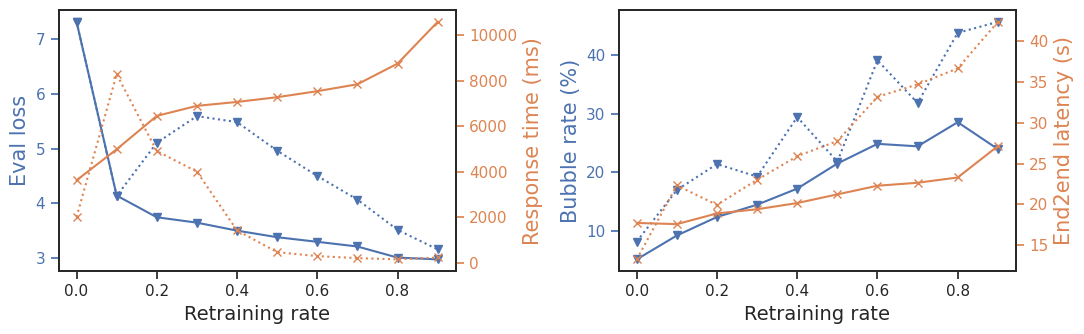

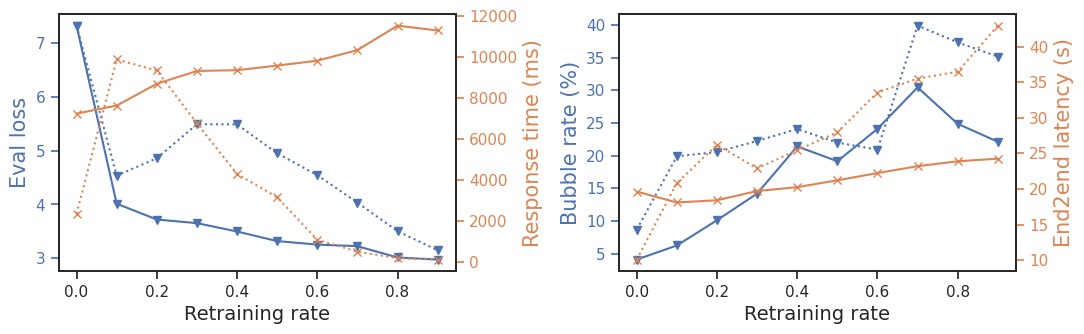

In [9]:
plot_dual(lambda_=10, figname="dialogpt-large_sep_mix_lambda=10_node=2", model='DialoGPT-large', legend=True, num_nodes=2)
plot_dual(lambda_=30, figname="dialogpt-large_sep_mix_lambda=30_node=2", model='DialoGPT-large', legend=False, num_nodes=2)
plot_dual(lambda_=50, figname="dialogpt-large_sep_mix_lambda=50_node=2", model='DialoGPT-large', legend=False, num_nodes=2)

#### 4-node

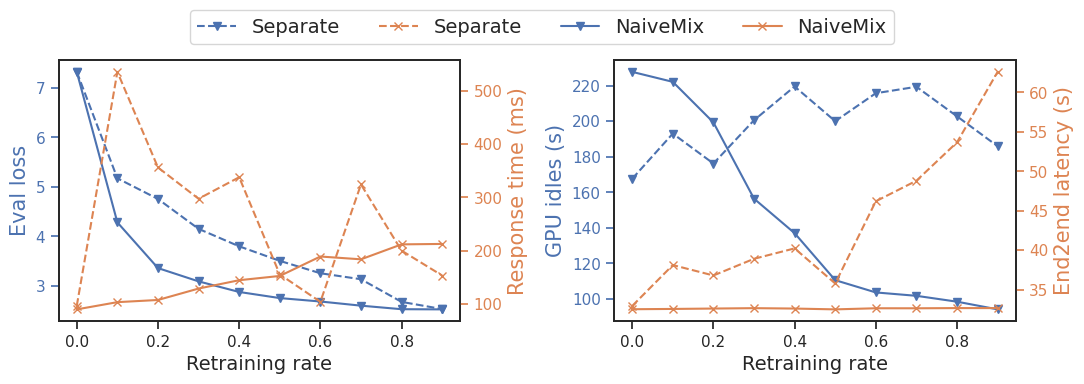

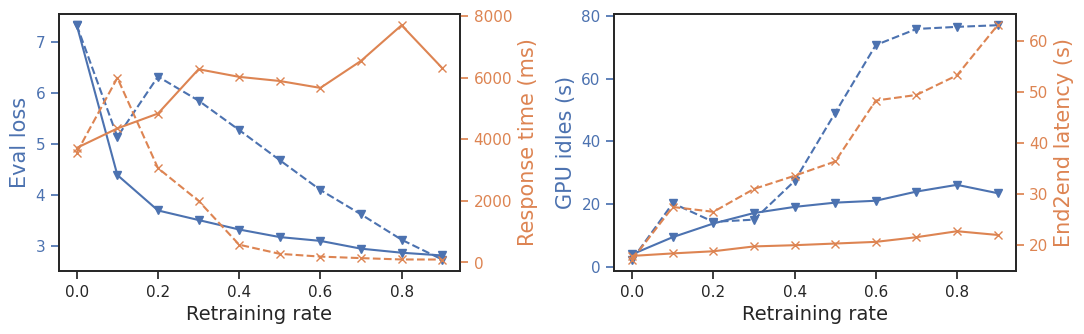

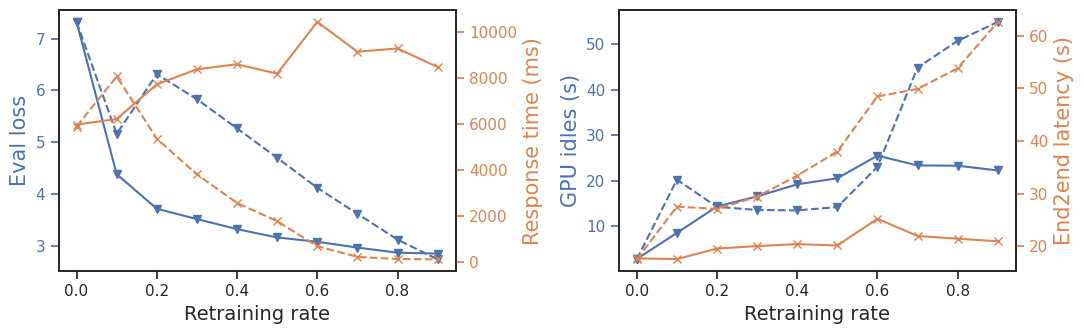

In [59]:
plot_dual(lambda_=10, figname="dialogpt-large_sep_mix_lambda=10_node=4", model='DialoGPT-large', legend=True, num_nodes=4)
plot_dual(lambda_=30, figname="dialogpt-large_sep_mix_lambda=30_node=4", model='DialoGPT-large', legend=False, num_nodes=4)
plot_dual(lambda_=50, figname="dialogpt-large_sep_mix_lambda=50_node=4", model='DialoGPT-large', legend=False, num_nodes=4)

## Improvement over NaiveMix

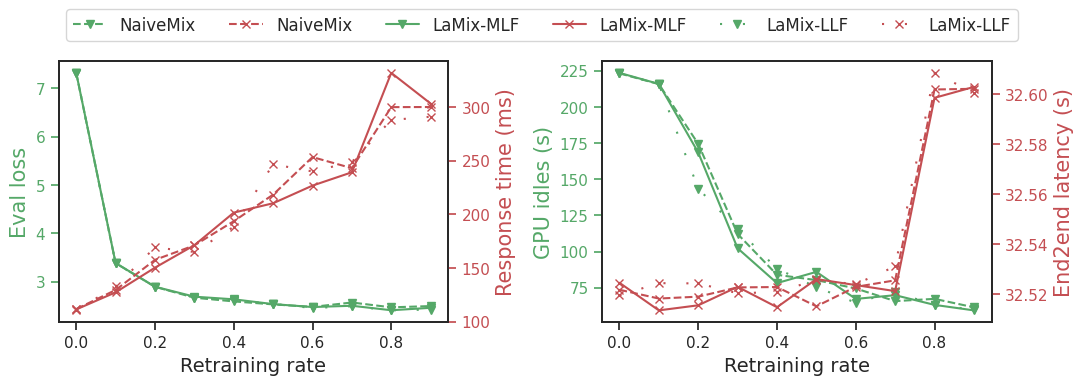

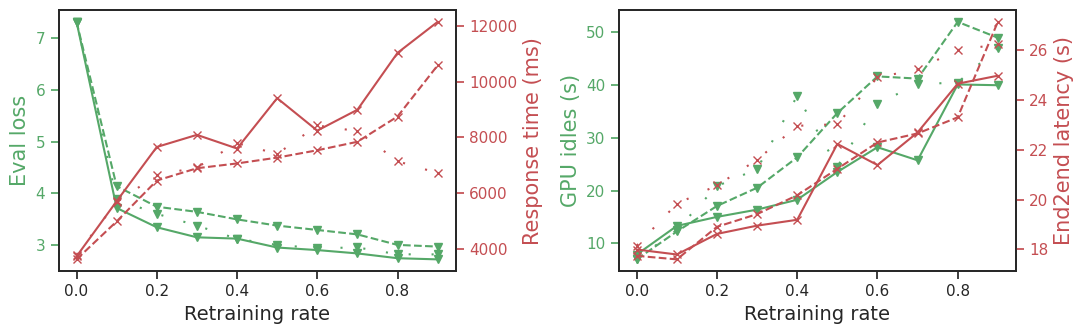

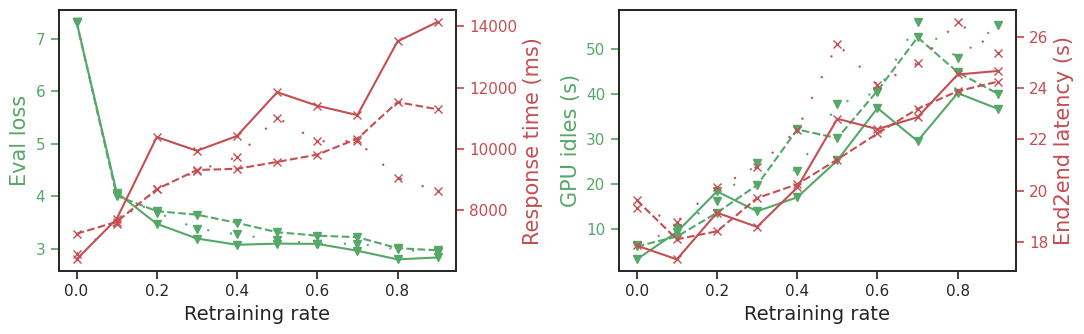

In [11]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=10_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=30_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=50_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

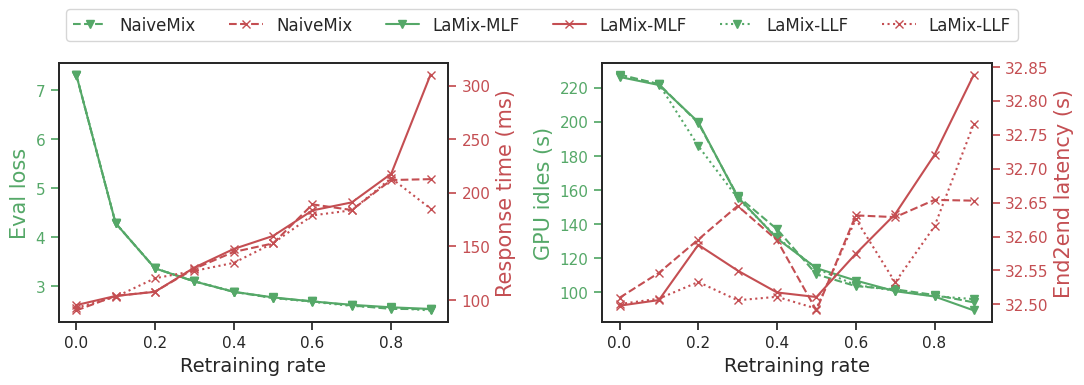

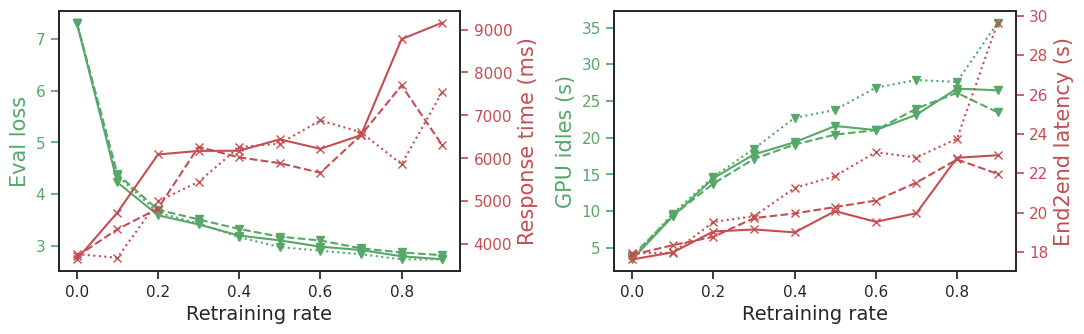

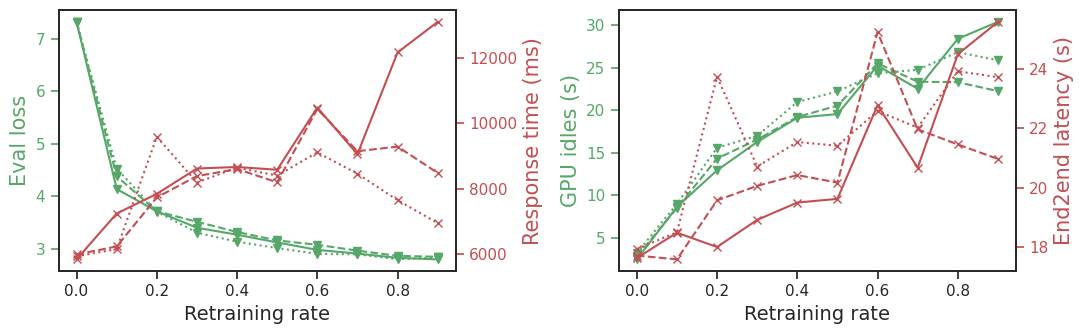

In [30]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=10_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=30_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-MLF", label3="LaMix-LLF", figname="dialogpt-large_improvement_lambda=50_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

### Load balancing

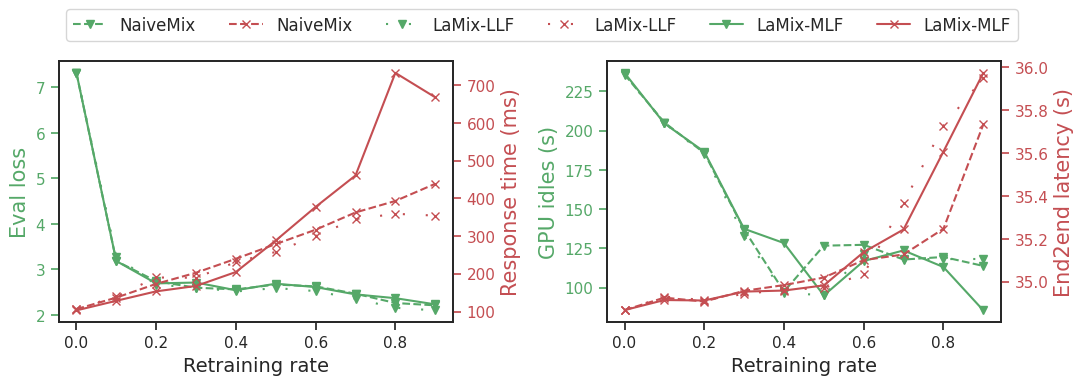

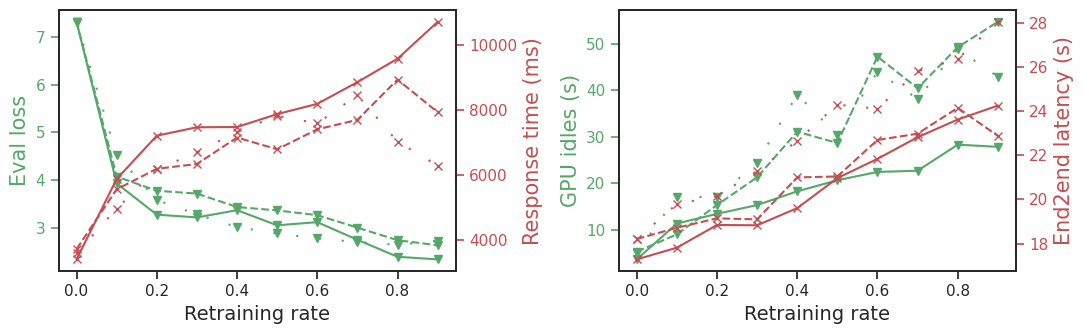

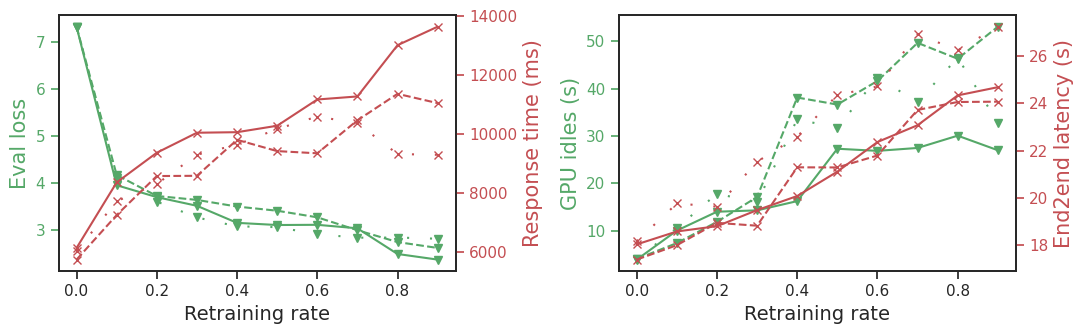

In [12]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=10_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=30_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-LLF", label3="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=50_node=2", 
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

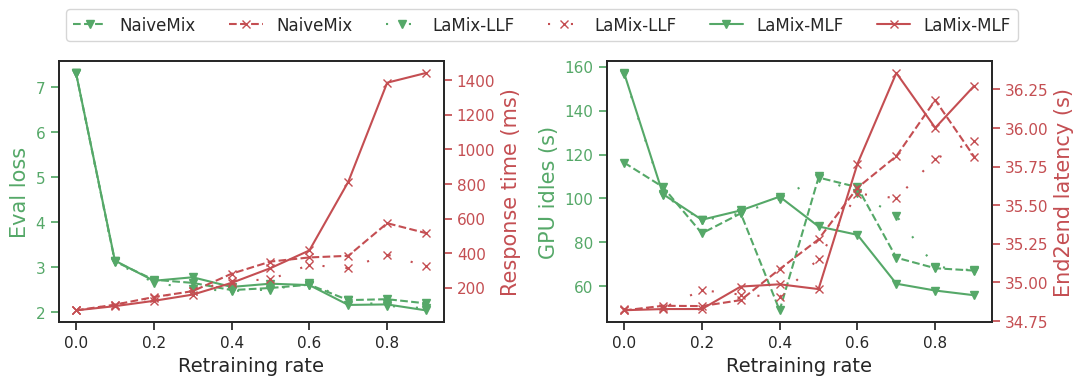

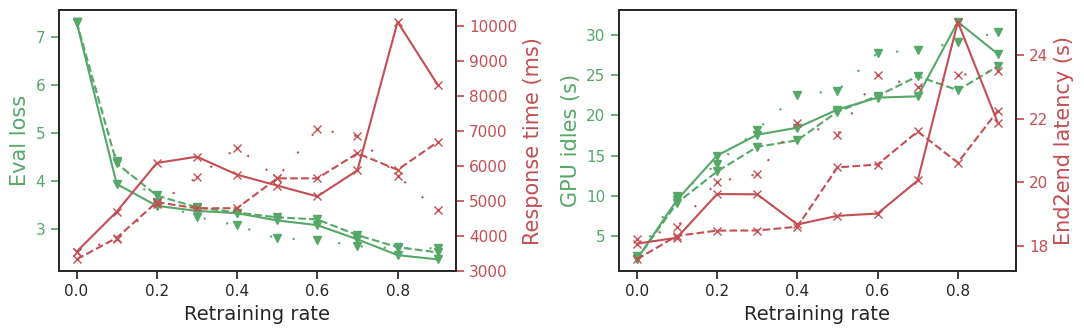

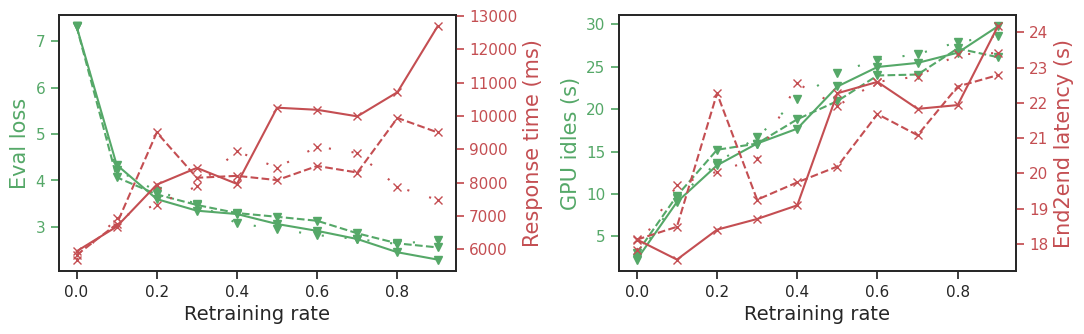

In [13]:
plot_dual(lambda_=10, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=10_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend_fontsize=12)
plot_dual(lambda_=30, label1="NaiveMix", label2="LaMix-LLF", label4="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=30_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label1="NaiveMix", label2="LaMix-LLF", label3="LaMix-MLF", load_balancing='workload', figname="dialogpt-large_balance_improvement_lambda=50_node=4", num_nodes=4,
          model='DialoGPT-large', color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

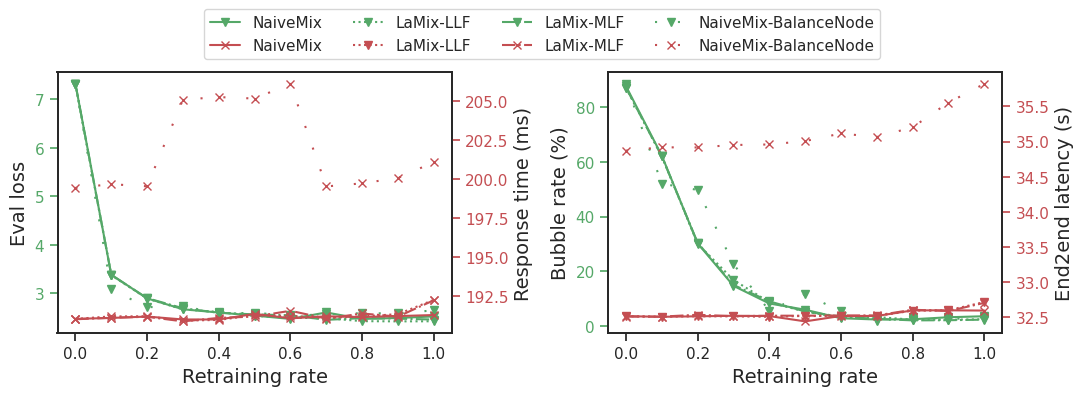

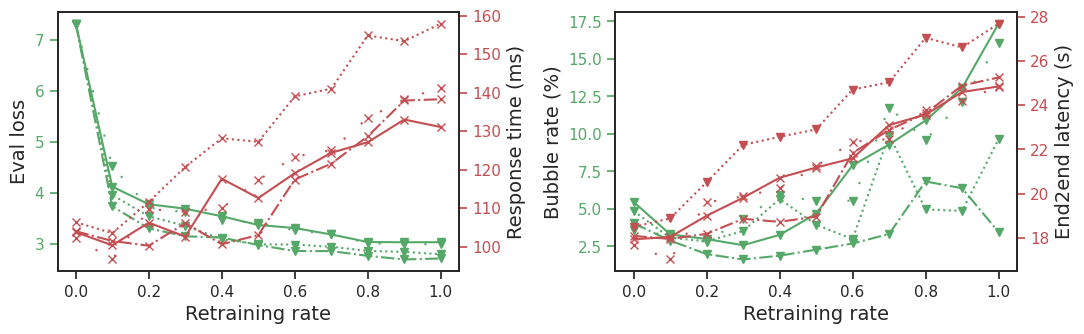

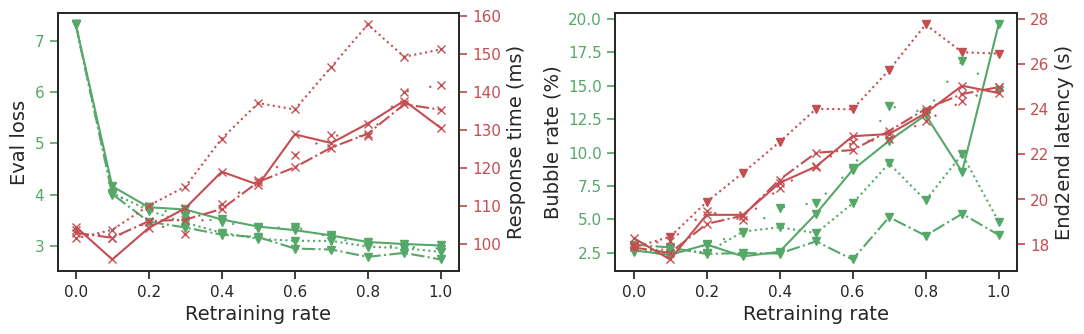

In [7]:
load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-BalanceNode', figname="dialogpt-large_workload_retraining_lambda=10_node=2", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=2, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-BalanceNode', figname="dialogpt-large_workload_retraining_lambda=30_node=2", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=2, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-BalanceNode', figname="dialogpt-large_workload_retraining_lambda=50_node=2", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=2, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

## 4-Node

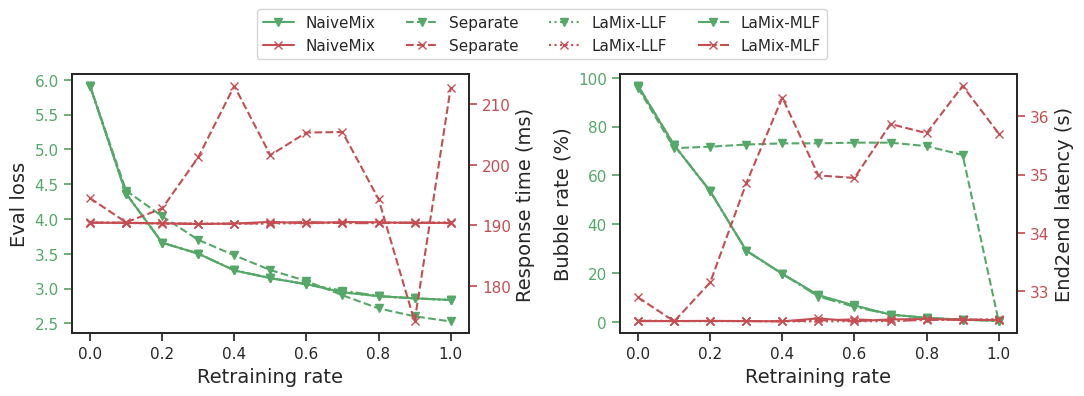

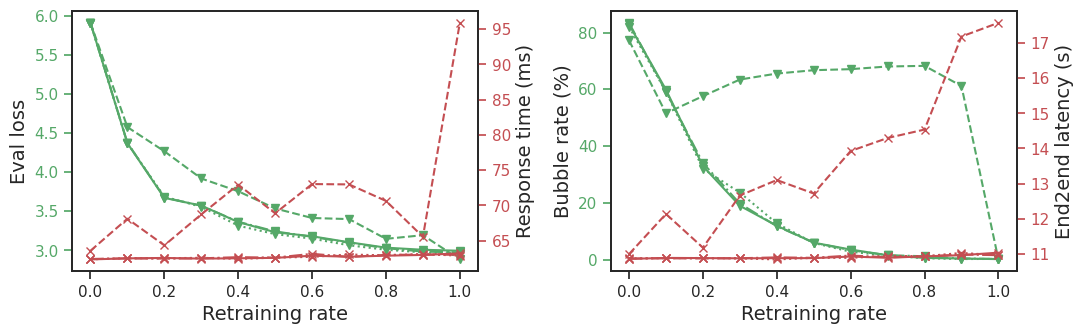

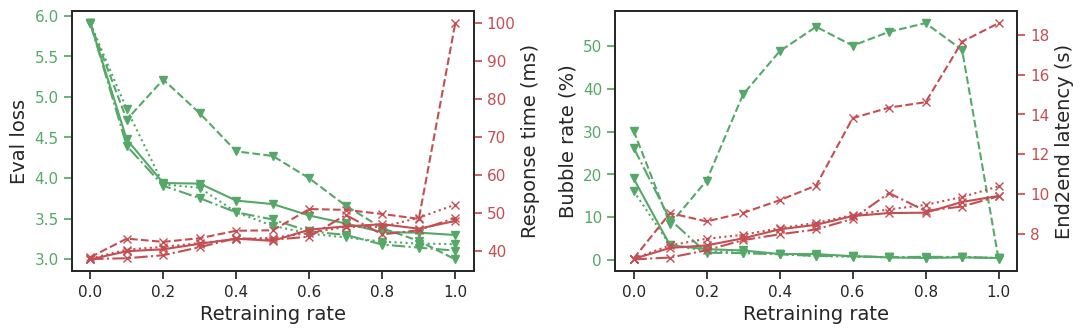

In [8]:
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-small_retraining_lambda=10_node=4", model='dialogpt-small',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-small_retraining_lambda=30_node=4", model='dialogpt-small',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-small_retraining_lambda=50_node=4", model='dialogpt-small',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

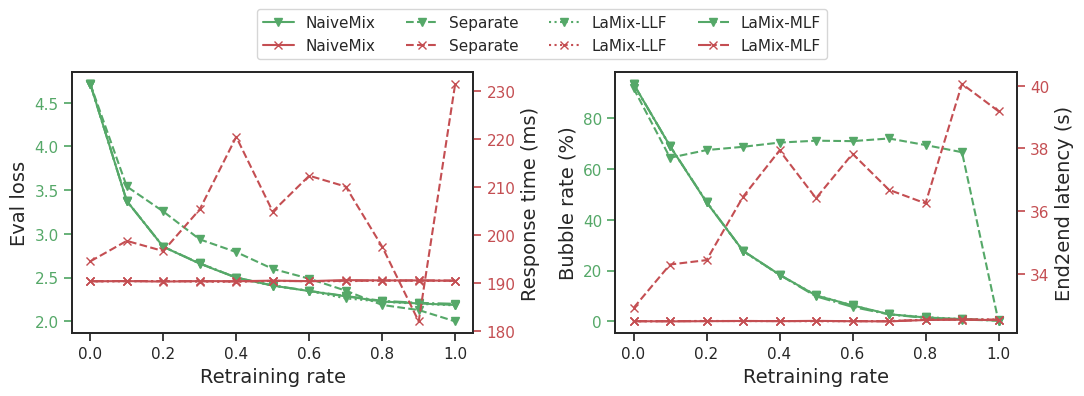

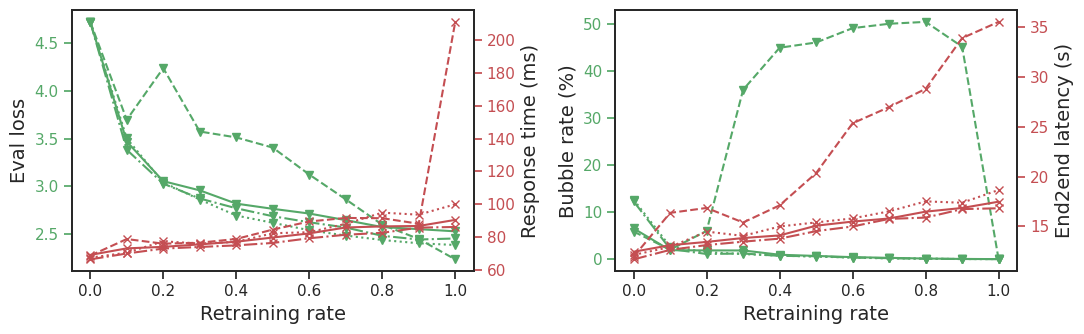

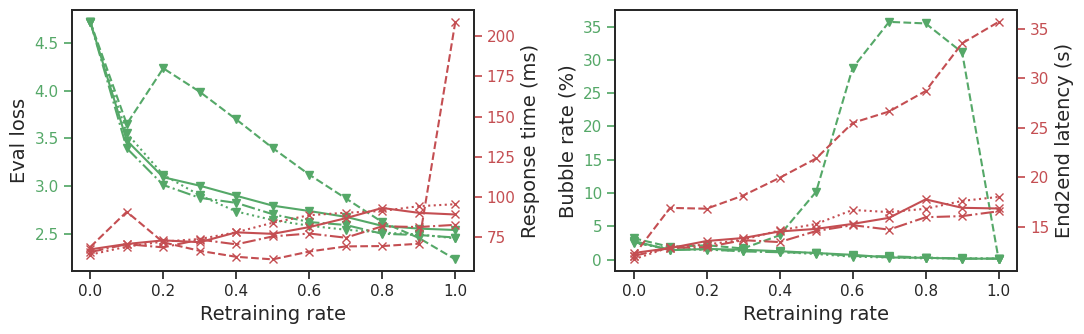

In [7]:
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-medium_retraining_lambda=10_node=4", model='dialogpt-medium',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-medium_retraining_lambda=30_node=4", model='dialogpt-medium',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-medium_retraining_lambda=50_node=4", model='dialogpt-medium',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

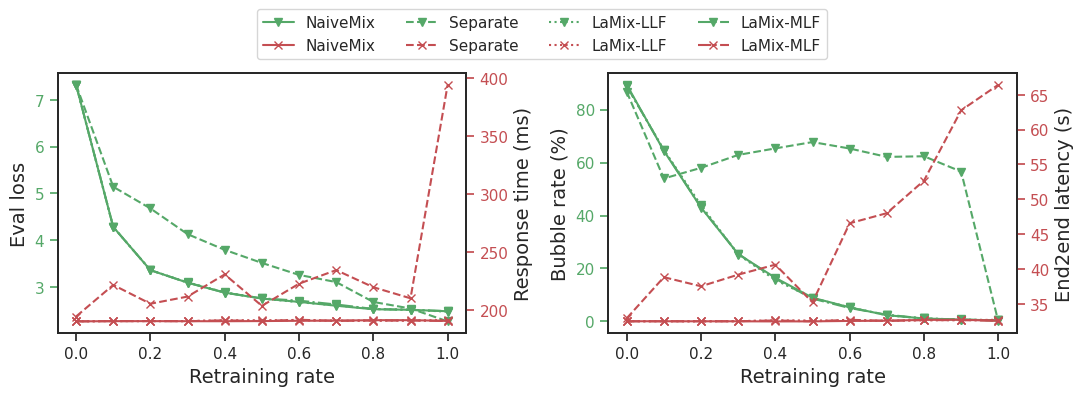

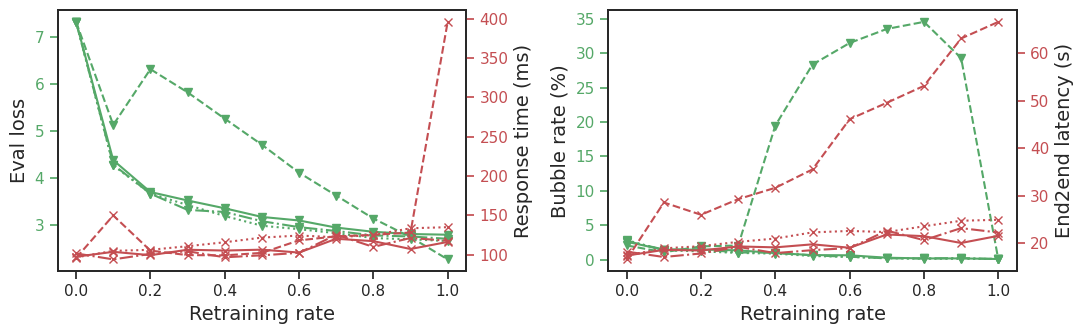

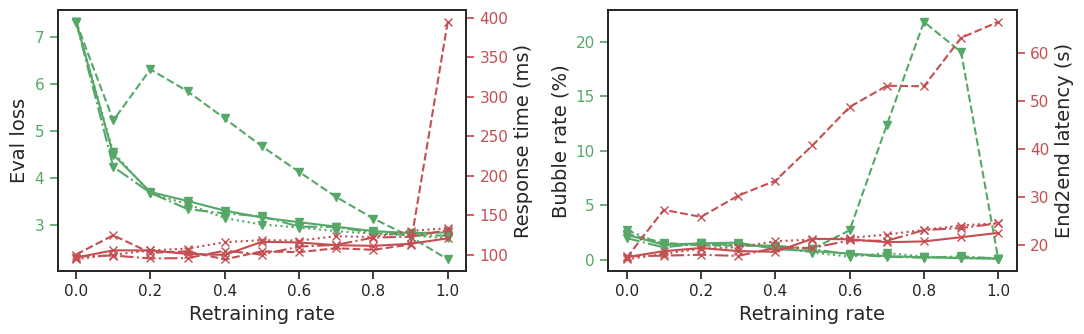

In [9]:
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-large_retraining_lambda=10_node=4", model='dialogpt-large',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-large_retraining_lambda=30_node=4", model='dialogpt-large',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", figname="dialogpt-large_retraining_lambda=50_node=4", model='dialogpt-large',
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

### Load balancing

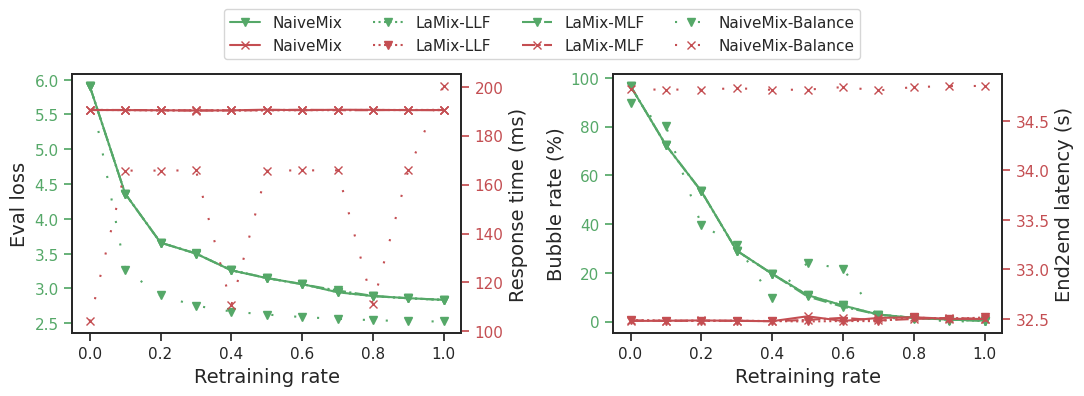

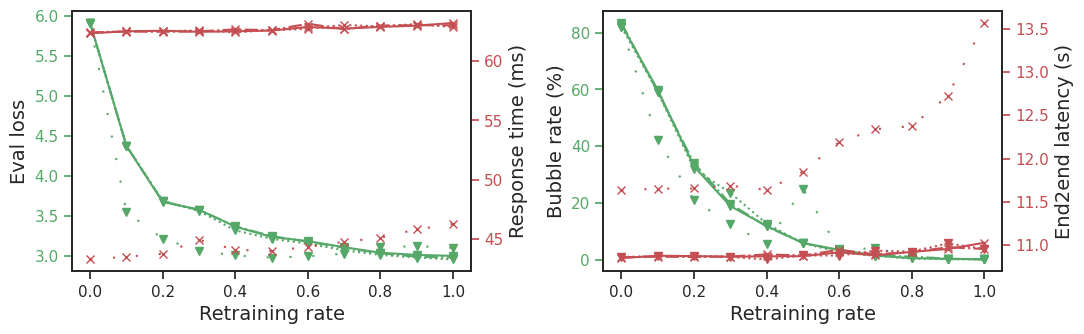

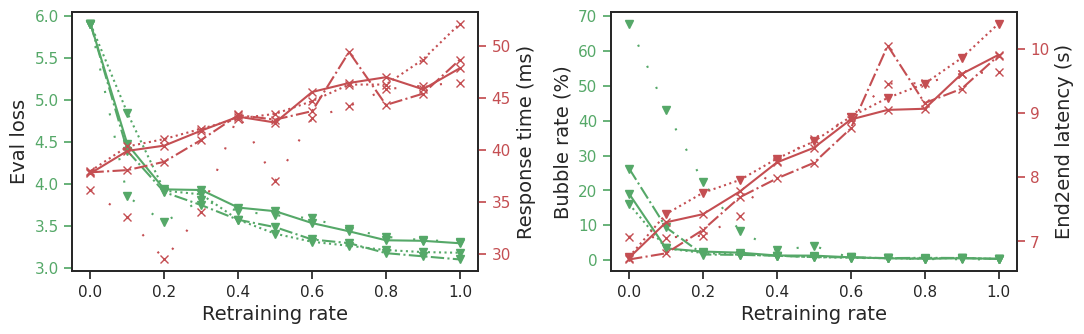

In [5]:
import sys 
sys.dont_write_bytecode = True
import seaborn as sns
from utils import plot_dual, plot_single

load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-small_workload_retraining_lambda=10_node=4", model='dialogpt-small', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-small_workload_retraining_lambda=30_node=4", model='dialogpt-small', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-small_workload_retraining_lambda=50_node=4", model='dialogpt-small', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

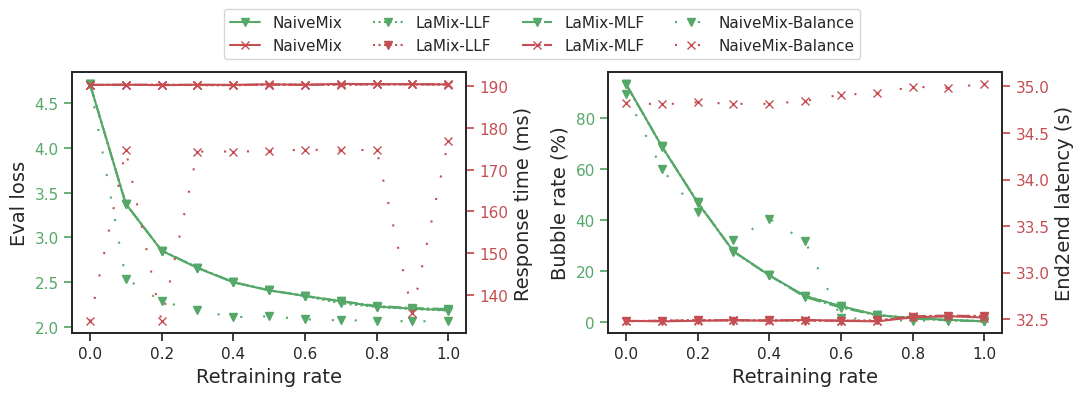

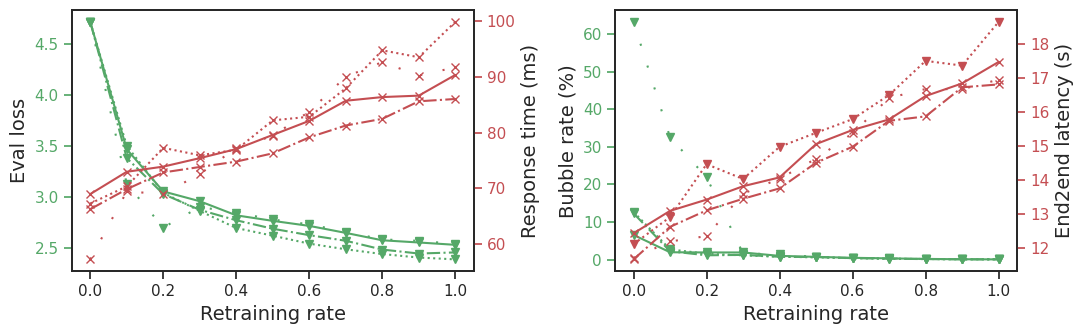

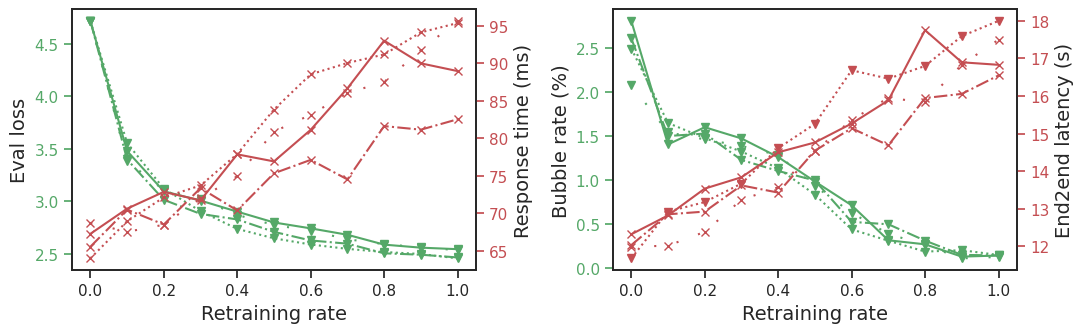

In [6]:
load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-medium_workload_retraining_lambda=10_node=4", model='dialogpt-medium', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-medium_workload_retraining_lambda=30_node=4", model='dialogpt-medium', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-medium_workload_retraining_lambda=50_node=4", model='dialogpt-medium', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

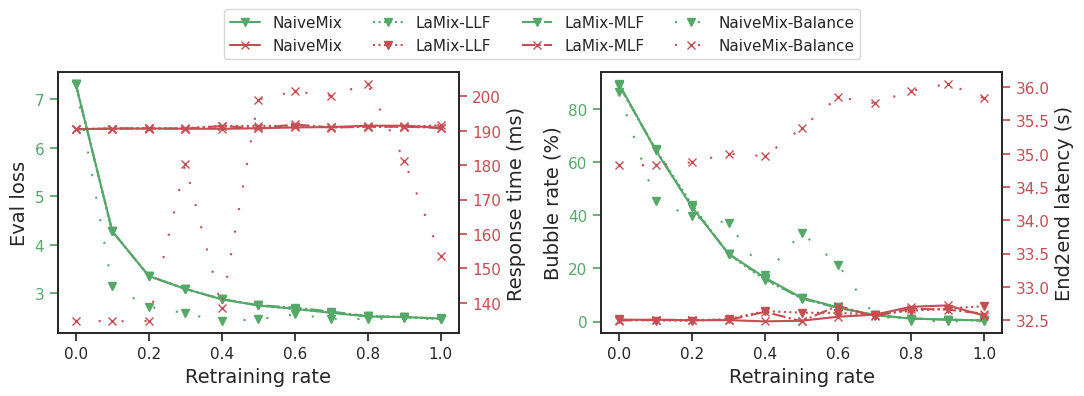

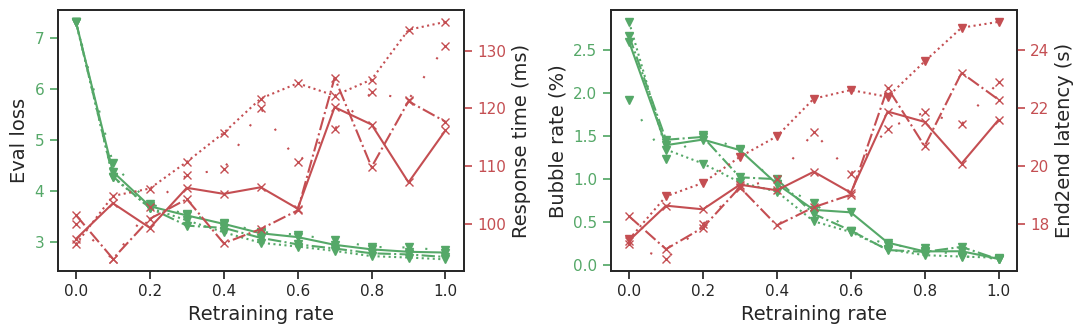

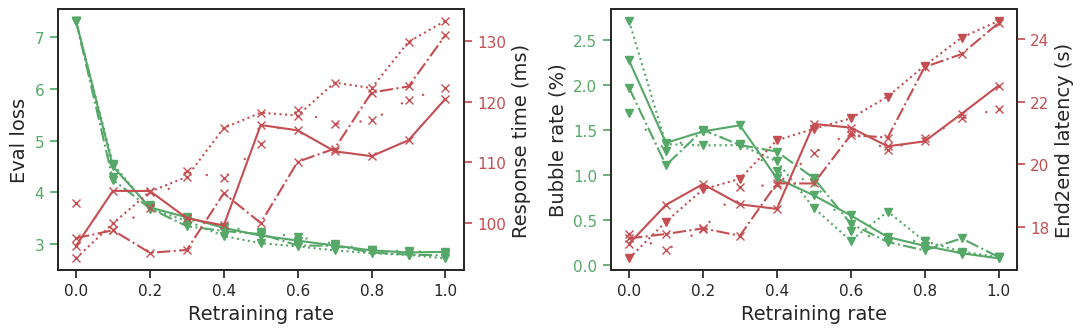

In [4]:
load_balancing = 'workload'
plot_dual(lambda_=10, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-large_workload_retraining_lambda=10_node=4", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3])
plot_dual(lambda_=30, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-large_workload_retraining_lambda=30_node=4", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)
plot_dual(lambda_=50, label3="LaMix-LLF", label4="LaMix-MLF", label5='NaiveMix-Balance', figname="dialogpt-large_workload_retraining_lambda=50_node=4", model='dialogpt-large', load_balancing=load_balancing,
          num_nodes=4, color1=sns.color_palette("deep")[2], color2=sns.color_palette("deep")[3], legend=False)

In [28]:
import random
random.expovariate(10)

0.08225579461673885